In [1]:
import scanpy as sc
import scanpy.external as sce
import os
import sys
p = os.path.abspath('../')
sys.path.append(p)
import rapids_scanpy_funcs as rap
import gpu_wrappers
sc.settings.verbosity=2

In [2]:
adata=sc.read('DentateGyrus.loom')
adata.obsm["X_tsne"]=adata.obs[['TSNE1','TSNE2']].values
adata.obs["Clusters"]=adata.obs["Clusters"].astype(str)

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [3]:
adata.var_names_make_unique()

In [4]:
adata=adata[adata.obs["Age"]=="P0"]

In [5]:
sc.pp.filter_genes(adata,min_cells=3)

filtered out 11750 genes that are detected in less than 3 cells
Trying to set attribute `.var` of view, copying.


In [6]:
import anndata2ri
anndata2ri.activate()
%load_ext rpy2.ipython

In [13]:
cnts

<8113x16248 sparse matrix of type '<class 'numpy.float32'>'
	with 15929106 stored elements in Compressed Sparse Row format>

In [7]:
cnts=adata.X
genes=adata.var_names
cells=adata.obs_names

In [14]:
%%R -i cnts -i genes -i cells -o ct
source("../CytoTRACE.R")
rownames(cnts)=cells
colnames(cnts)=genes
results=CytoTRACE(as.matrix(t(cnts)),ncores=16)
ct=results$CytoTRACE

R[write to console]: The number of cells in your dataset exceeds 3,000. CytoTRACE will now be run in fast mode (see documentation). You can multi-thread this run using the 'ncores' flag. To disable fast mode, please indicate 'enableFast = FALSE'.

R[write to console]: CytoTRACE will be run on 8 sub-sample(s) of approximately 1014 cells each using 8 / 16 core(s)

R[write to console]: Pre-processing data and generating similarity matrix...

R[write to console]: Calculating gene counts signature...

R[write to console]: Smoothing values with NNLS regression and diffusion...

R[write to console]: Calculating genes associated with CytoTRACE...

R[write to console]: Done



... storing 'Age' as categorical
... storing 'Cell_Conc' as categorical
... storing 'ChipID' as categorical
... storing 'ClusterName' as categorical
... storing 'Clusters' as categorical
... storing 'Comments' as categorical
... storing 'Date_Captured' as categorical
... storing 'DonorID' as categorical
... storing 'Label' as categorical
... storing 'NGI_PlateWell' as categorical
... storing 'Num_Pooled_Animals' as categorical
... storing 'PCR_Cycles' as categorical
... storing 'Plug_Date' as categorical
... storing 'Project' as categorical
... storing 'SampleID' as categorical
... storing 'SampleOK' as categorical
... storing 'Sample_Index' as categorical
... storing 'Seq_Comment' as categorical
... storing 'Seq_Lib_Date' as categorical
... storing 'Seq_Lib_Ok' as categorical
... storing 'Serial_Number' as categorical
... storing 'Sex' as categorical
... storing 'Species' as categorical
... storing 'Strain' as categorical
... storing 'Target_Num_Cells' as categorical
... storing 'Tiss

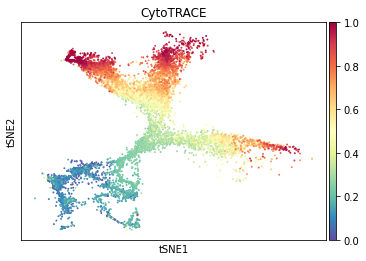

In [15]:
adata.obs["CytoTRACE"]=ct

sc.pl.tsne(adata,color="CytoTRACE",cmap="Spectral_r")

In [16]:
adata

AnnData object with n_obs × n_vars = 8113 × 16248
    obs: 'Age', 'Cell_Conc', 'ChipID', 'ClusterName', 'Clusters', 'Comments', 'Date_Captured', 'DonorID', 'Label', 'NGI_PlateWell', 'Num_Pooled_Animals', 'PCR_Cycles', 'Plug_Date', 'Project', 'SampleID', 'SampleOK', 'Sample_Index', 'Seq_Comment', 'Seq_Lib_Date', 'Seq_Lib_Ok', 'Serial_Number', 'Sex', 'Species', 'Strain', 'TSNE1', 'TSNE2', 'Target_Num_Cells', 'Tissue', 'Transcriptome', 'cDNA_Lib_Ok', 'ngperul_cDNA', 'CytoTRACE'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'n_cells'
    obsm: 'X_tsne'
    layers: 'matrix', 'ambiguous', 'spliced', 'unspliced'

In [17]:
sc.pp.normalize_total(adata,target_sum=1e6)

normalizing counts per cell
    finished (0:00:00)


In [18]:
sc.pp.log1p(adata,base=10)

In [19]:
sc.pp.highly_variable_genes(adata,flavor='cell_ranger')

extracting highly variable genes
    finished (0:00:00)


In [20]:
import cupy as cp
scaled=rap.scale(cp.array(adata[:,adata.var.highly_variable].X.A))

In [21]:
from cuml import PCA
adata.obsm["X_pca"] = (PCA(n_components=100).fit_transform(scaled)).get()

In [22]:
sc.pp.neighbors(adata,n_neighbors=20,n_pcs=100,metric='correlation')

computing neighbors
    using 'X_pca' with n_pcs = 100
    finished (0:00:24)


In [23]:
sc.tl.umap(adata)

computing UMAP
    finished (0:00:07)


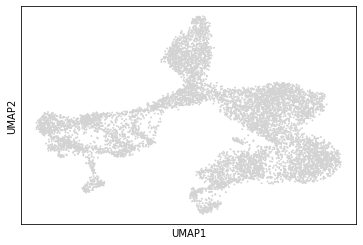

In [24]:
sc.pl.umap(adata)

In [26]:
gpu_wrappers.draw_graph(adata,init_pos="X_tsne")

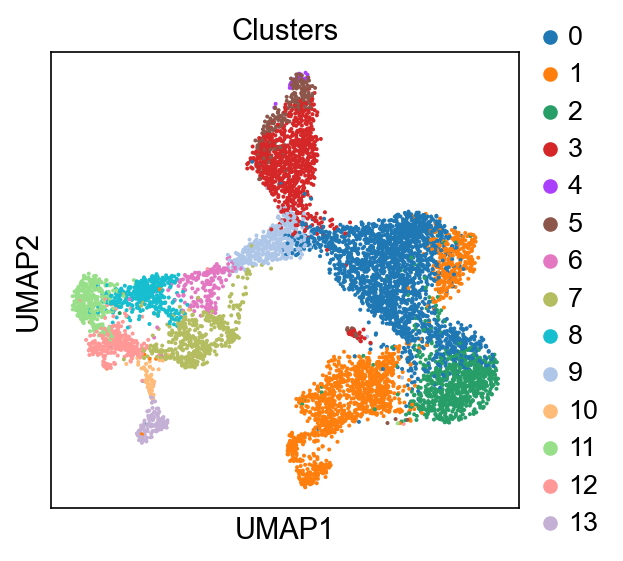

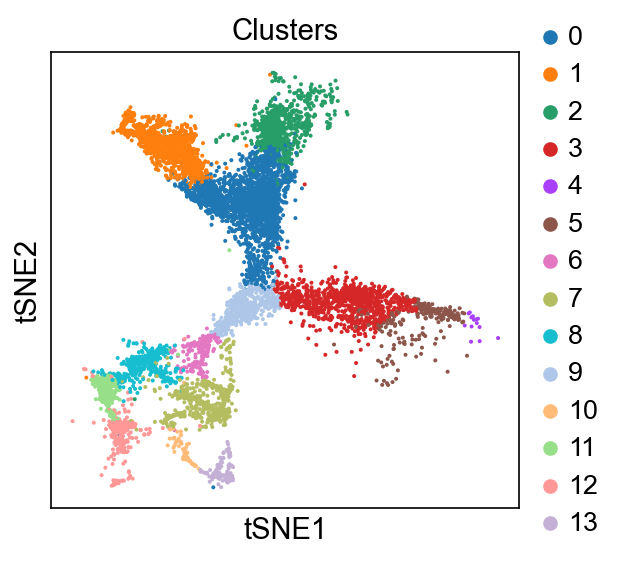

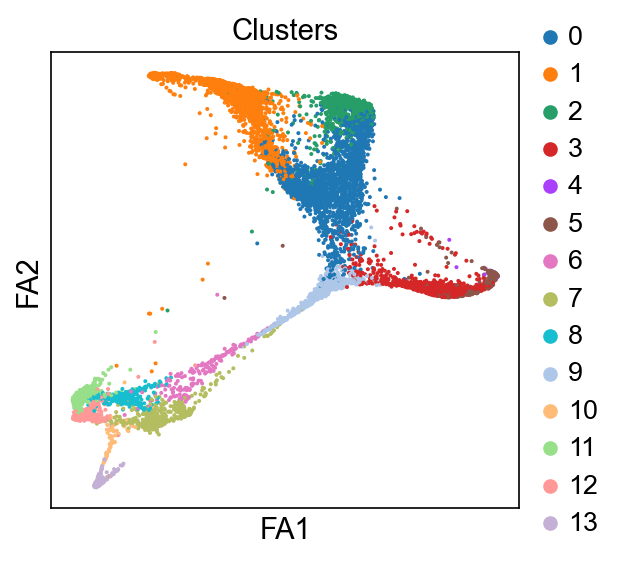

In [27]:
sc.set_figure_params(dpi=150)
sc.pl.umap(adata,color='Clusters')
sc.pl.tsne(adata,color='Clusters')
sc.pl.draw_graph(adata,color='Clusters')

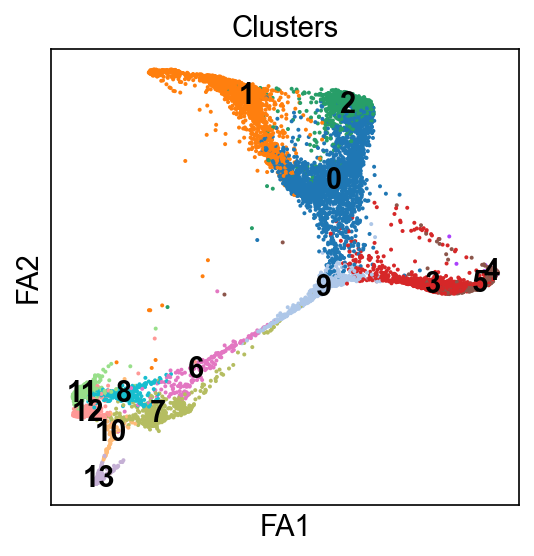

In [28]:
sc.pl.draw_graph(adata,color="Clusters",legend_loc="on data")

In [30]:
adata=adata[adata.obs.Clusters.isin(["6","9","0","2","1","3","5","4"])]

In [31]:
import scFates as scf

In [32]:
scf.pp.diffusion(adata)

findfont: Font family ['Raleway'] not found. Falling back to DejaVu Sans.
computing neighbors


Running Diffusion maps 
Determing nearest neighbor graph...


    finished (0:00:01)


    determining multiscale diffusion space
    finished (0:00:02) --> added 
    .obsm['X_diffusion_multiscale'], multiscale diffusion space.
    .uns['diffusion'] dict containing diffusion maps results.


In [33]:
sc.pp.neighbors(adata,n_neighbors=30,use_rep="X_diffusion_multiscale")

computing neighbors
    finished (0:00:02)


In [36]:
gpu_wrappers.draw_graph(adata,init_pos="X_umap")

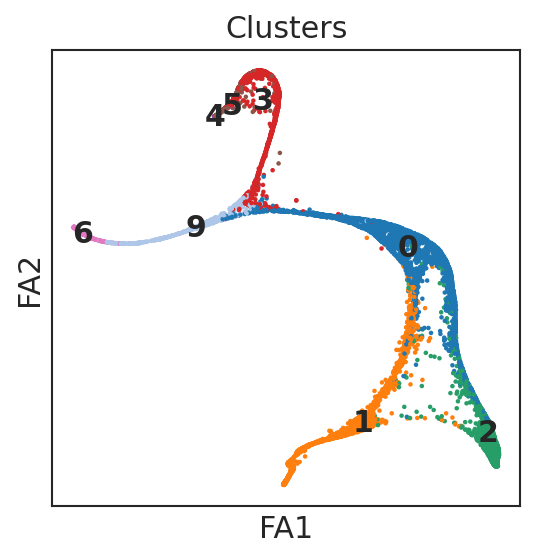

In [37]:
sc.pl.draw_graph(adata,color="Clusters",legend_loc="on data")

In [39]:
del adata.uns["diffusion"]
adata.write("adata_preprocess.h5ad")